In [1]:
!pip install -r https://raw.githubusercontent.com/veselm73/BP/main/requirements_SDUEBA010.txt --quiet
!wget -q -O SDUEBA_utils.py https://raw.githubusercontent.com/veselm73/BP/main/SDUEBA_utils.py
!pip install umap-learn --quiet
!pip install gensim --quier
!pip install kagglehub --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━

In [1]:
# Dependencies
import os
import re
import string
import numpy as np
import pandas as pd
import scipy
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import torch
import gensim
import umap.umap_ as umap
import kagglehub
import urllib.request

In [10]:
#SDUEBA Parameters:
"""
vector_space_dimension  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
"""
frac_of_dataset = 0.01
n_features = 20

#Embeddings parameters:
embedding_method = "word2vec"
vector_space_dimension = 80
descriptive_format = True
weighted_embeddings = False
use_bias = True

#Clustering parameters:
if use_bias:
    alpha_weight = 1
    bias_method = "one_hot"         #"one_hot"/"perpendicular"

#Clustering parameters
clustering_method = "hdbscan"       #"agglomerative"/"spherical_kmeans"/"tspg"/"hdbscan"
#One of these two has to be None, for kmeans dendogram_cut = None
n_clusters = 100
dendrogram_cut = None




max_depth = 3
test_size = 0.2
tree_accuracy_threshold = 0.95
target_column = "Severity"
target_value = 3

len_dataset = 7700000
#Quality metric parameters
description_length_limit = 3
difference_limit = 0
subgroup_size_limit = int(0.01*frac_of_dataset*len_dataset)
print(f"Subgroup size limit: {subgroup_size_limit}")

Subgroup size limit: 770


In [11]:
#Data loading

def load_shorter_sample(file_path, frac=0.01):
    assert 0 < frac < 1, "Fraction must be between 0 and 1"

    with open(file_path, 'r') as f:
        total_lines = sum(1 for _ in f) - 1

    sample_size = int(total_lines * frac)

    skip = sorted(np.random.choice(
        np.arange(1, total_lines + 1),
        total_lines - sample_size,
        replace=False
    ))

    df = pd.read_csv(file_path, skiprows=skip, low_memory=False)

    return df


path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
file_path = os.path.join(path, "US_Accidents_March23.csv")

df = load_shorter_sample(file_path, frac=frac_of_dataset)
print(df.columns)

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


<Axes: >

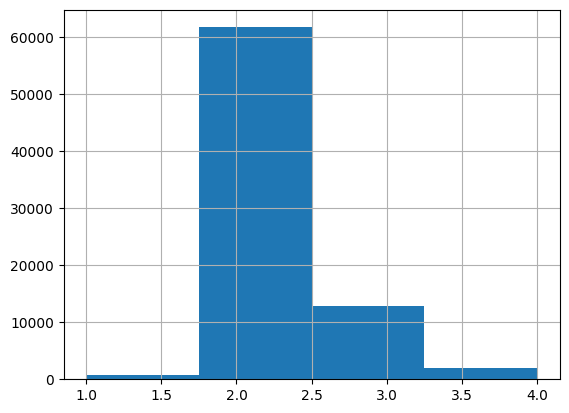

In [12]:
df[target_column].hist(bins=4)

In [13]:
#Data augmentation
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

exclude_from_sentences = [
    target_column,
    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'
]

columns_to_drop = [
    'ID', 'Source', 'End_Time', 'End_Lat', 'End_Lng', 'Distance(mi)',
    'Description', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
    'Weather_Timestamp', 'Turning_Loop', 'Astronomical_Twilight',
    'Nautical_Twilight', 'Civil_Twilight', 'Start_Lat', 'Start_Lng',
    'Wind_Direction'
]


df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['Time'] = df['Start_Time'].dt.hour.astype('Int64')
df['Time'] = df['Time'].apply(lambda x: f"Hour {x}" if pd.notnull(x) else "Unknown")
df = df.drop(columns=['Start_Time'], errors='ignore')


df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

df=df.fillna('Unknown')

numerical_cols = df.select_dtypes(include=[np.number]).columns.drop(target_column, errors='ignore')
X = df[numerical_cols]
y = df[target_column]

if len(X.columns) > 0:
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    def normalize_weights(weights):
        arr = np.array(weights)
        return (arr - arr.min()) / (arr.max() - arr.min()) if arr.max() != arr.min() else np.zeros_like(arr)

    feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': normalize_weights(model.feature_importances_)})

    feature_weights = pd.concat([feature_weights,pd.DataFrame({'Feature': [target_column], 'Weight': [1.0]})], ignore_index=True)

    top_features = feature_weights.sort_values(by='Weight', ascending=False).head(n_features)['Feature'].tolist()
else:
    top_features = df.columns.drop(target_column).tolist()


features_raw = df[top_features].copy()
if target_column in features_raw.columns:
    features_raw = features_raw.drop(columns=[target_column])

categorical_columns = features_raw.select_dtypes(include='object').columns.tolist()

if 'Time' in features_raw.columns and 'Time' not in categorical_columns:
    categorical_columns.append('Time')

target_df = df[[target_column]]

#Supervised embedding if use_bias
categorical_columns = [col for col in categorical_columns if col not in exclude_from_sentences]
if use_bias:
    categorical_df = pd.concat([df[categorical_columns].astype(str), df[[target_column]].astype(str)], axis=1)
else:
    categorical_df = df[categorical_columns].astype(str)



binary_candidates = features_raw.select_dtypes(include=['bool']).copy()
binary_df = binary_candidates[[col for col in binary_candidates.columns if features_raw[col].nunique() == 2]]

numerical_df = features_raw.loc[:, lambda df_: [col for col in df_.columns if col not in categorical_df.columns and col not in binary_df.columns and col not in target_df.columns]]
numerical_df = numerical_df.replace("Unknown", np.nan)

numerical_df = numerical_df.apply(pd.to_numeric, errors='coerce')
imputer = SimpleImputer(strategy='mean')
numerical_df = pd.DataFrame(imputer.fit_transform(numerical_df), columns=numerical_df.columns)
numerical_df = pd.DataFrame(imputer.fit_transform(numerical_df), columns=numerical_df.columns)



class SentenceFormatter:
    def __init__(self, dataframe, descriptive_format=True):
        self.df = dataframe.copy()
        self.descriptive_format = descriptive_format

    def _prettify_column_names(self):
        return [' '.join(col.split('_')) for col in self.df.columns]

    def generate_sentences(self):
        sentences = []
        if self.descriptive_format:
            pretty_columns = self._prettify_column_names()
            for _, row in self.df.iterrows():
                sentence = []
                for col_name, val in zip(pretty_columns, row):
                    phrase = f"{col_name} is {val}"
                    sentence.extend(phrase.lower().split())
                sentences.append(sentence)
        else:
            for _, row in self.df.iterrows():
                sentence = [str(val).lower() for val in row]
                sentences.append(sentence)
        return sentences


formatter = SentenceFormatter(categorical_df, descriptive_format=True)
sentences = formatter.generate_sentences()

print(sentences[0])

['street', 'is', 'north', 'fwy', 's', 'city', 'is', 'columbus', 'county', 'is', 'franklin', 'state', 'is', 'oh', 'weather', 'condition', 'is', 'overcast', 'sunrise', 'sunset', 'is', 'day', 'time', 'is', 'hour', '12', 'severity', 'is', '3']


In [14]:
binary_df.head()

,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False


In [15]:
numerical_df.head()

,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
0,37.0,32.400000,96.0,29.63,8.0,5.800000,0.00000
1,30.9,22.800000,76.0,29.81,6.0,9.200000,0.00836
2,26.1,58.330687,81.0,30.50,5.0,7.690547,0.00836
3,79.0,58.330687,38.0,30.01,10.0,12.700000,0.00836
4,57.9,58.330687,75.0,30.04,10.0,4.600000,0.00836


In [16]:
#Word2Vec/Bert training and clustering
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel
import hdbscan

def clear_cuda_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

class Word2VecModel:
    def __init__(self, sentences, vector_size=vector_space_dimension, window=15, min_count=1):
        self.model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count)

    def get_embedding(self, sentence, weighted_embeddings=False, feature_weights=None):
        word_embeddings = [self.model.wv[word] for word in sentence if word in self.model.wv]
        if not word_embeddings:
            return np.zeros(self.model.vector_size)

        if weighted_embeddings and feature_weights is not None:
            weights = np.array(feature_weights['Weight'].tolist())
            return np.average(word_embeddings, axis=0, weights=weights)
        return np.mean(word_embeddings, axis=0)

class BertEmbedder:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2", device=None, batch_size=16):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device).half()
        self.batch_size = batch_size

    def get_embedding(self, sentences):
        if isinstance(sentences[0], list):
            sentences = [" ".join(sentence) for sentence in sentences]

        embeddings = []
        for i in range(0, len(sentences), self.batch_size):
            batch = sentences[i:i + self.batch_size]
            inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256).to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

        return np.vstack(embeddings)

class SentenceEmbedder:
    def __init__(self, method="word2vec", **kwargs):
        self.method = method.lower()

        if self.method == "word2vec":
            self.model = Word2VecModel(**kwargs)
        elif self.method == "bert":
            self.model = BertEmbedder(**kwargs)
        else:
            raise ValueError("Unsupported embedding method. Use 'word2vec' or 'bert'.")

    def generate_embeddings(self, sentences, normalize=False, weighted_embeddings=False, feature_weights=None):
        if self.method == "word2vec":
            embeddings = np.array([
                self.model.get_embedding(s, weighted_embeddings=weighted_embeddings, feature_weights=feature_weights)
                for s in sentences
            ])
        elif self.method == "bert":
            embeddings = self.model.get_embedding(sentences)
        else:
            raise ValueError("Unsupported embedding method.")

        if normalize:
            norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
            norms[norms == 0] = 1  # Avoid division by zero
            embeddings = embeddings / norms

        return embeddings


class NumericalEmbedder:
    def __init__(self, n_components=16, scaler=None, reducer=None):
        self.n_components = n_components
        self.scaler = scaler or StandardScaler()
        self.reducer = reducer or PCA(n_components=n_components)
        self.fitted = False

    def fit(self, X):
        X_scaled = self.scaler.fit_transform(X)
        self.reducer.fit(X_scaled)
        self.fitted = True

    def transform(self, X):
        if not self.fitted:
            raise ValueError("NumericalEmbedder must be fitted before calling transform.")
        X_scaled = self.scaler.transform(X)
        return self.reducer.transform(X_scaled)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


class BinaryEmbedder:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.reducer = PCA(n_components=n_components) if n_components is not None else None
        self.fitted = False

    def fit(self, X):
        if self.reducer:
            self.reducer.fit(X)
        self.fitted = True

    def transform(self, X):
        if self.reducer:
            return self.reducer.transform(X)
        return X.astype(np.float32)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


class BiasedEmbedder:
    def __init__(self, alpha=0.1, random_state=73, bias_method="one_hot", use_bias=True):
        self.use_bias = use_bias
        self.alpha = alpha
        self.random_state = random_state
        self.bias_method = bias_method.lower() if bias_method is not None else None

        if self.use_bias:
            self._validate_bias_method()

    def _validate_bias_method(self):
        if self.bias_method is None:
            return
        elif self.bias_method not in ["one_hot", "perpendicular"]:
            raise ValueError(f"Unsupported bias method: {self.bias_method}. Choose 'one_hot', 'perpendicular', or None.")

    def apply_bias(self, embeddings, targets):
        if not self.use_bias or self.bias_method is None:
            return embeddings

        if self.bias_method == "one_hot":
            return self._one_hot_bias_embeddings(embeddings, targets)
        elif self.bias_method == "perpendicular":
            return self._perpendicular_bias_embeddings(embeddings, targets)

    def _perpendicular_bias_embeddings(self, embeddings, targets):
        embeddings_biased = np.copy(embeddings)
        unique_classes, targets_encoded = np.unique(targets, return_inverse=True)
        np.random.seed(self.random_state)

        if len(unique_classes) > embeddings.shape[1]:
            raise ValueError("Number of unique classes exceeds embedding dimension, cannot create perpendicular biases.")

        bias_vectors = np.eye(len(unique_classes), embeddings.shape[1])

        for i, class_idx in enumerate(targets_encoded):
            embeddings_biased[i] += self.alpha * bias_vectors[class_idx]

        return embeddings_biased

    def _one_hot_bias_embeddings(self, embeddings, targets):
        unique_classes, targets_encoded = np.unique(targets, return_inverse=True)

        embeddings_extended = np.zeros((embeddings.shape[0], embeddings.shape[1] + len(unique_classes)))
        embeddings_extended[:, :embeddings.shape[1]] = embeddings

        for i, class_idx in enumerate(targets_encoded):
            embeddings_extended[i, embeddings.shape[1] + class_idx] = self.alpha

        return embeddings_extended

class EmbeddingPipeline:
    def __init__(self,
                 sentence_embedder,
                 numerical_embedder,
                 binary_embedder,
                 weights=None,
                 bias_config=None,
                 normalize=True):
        self.sentence_embedder = sentence_embedder
        self.numerical_embedder = numerical_embedder
        self.binary_embedder = binary_embedder
        self.weights = weights
        self.bias = bias_config  # Should be a BiasedEmbedder instance or None
        self.normalize = normalize

    def _normalize(self, X):
        return StandardScaler().fit_transform(X) if self.normalize else X

    def run(self, sentences, numerical_df, binary_df, targets=None):
        emb_sent = self._normalize(self.sentence_embedder.generate_embeddings(sentences))
        emb_num  = self._normalize(self.numerical_embedder.fit_transform(numerical_df))
        emb_bin  = self._normalize(self.binary_embedder.fit_transform(binary_df))

        blocks = [emb_sent, emb_num, emb_bin]
        if self.weights:
            blocks = [b * w for b, w in zip(blocks, self.weights)]

        merged = np.concatenate(blocks, axis=1)

        if self.bias and targets is not None:
            merged = self.bias.apply_bias(merged, targets)

        return merged



class ClusteringModel:
    def __init__(self, n_clusters=None, method="agglomerative", random_state=73,
                 dendrogram_cut=None, hdbscan_min_cluster_size=None, use_umap=True, umap_dim=10):
        self.n_clusters = n_clusters
        self.method = method
        self.random_state = random_state
        self.dendrogram_cut = dendrogram_cut
        self.hdbscan_min_cluster_size = hdbscan_min_cluster_size or 15
        self.use_umap = use_umap
        self.umap_dim = umap_dim
        self.linkage_matrix = None

    def fit_predict(self, embeddings):
        clustering_methods = {
            "spherical_kmeans": self._spherical_kmeans_clustering,
            "agglomerative": self._agglomerative_clustering,
            "tspg": self._tspg_clustering,
            "hdbscan": self._hdbscan_clustering
        }

        if self.method in clustering_methods:
            return clustering_methods[self.method](embeddings)

        raise ValueError(f"Unsupported clustering method: {self.method}")

    def _spherical_kmeans_clustering(self, X):
        np.random.seed(self.random_state)
        X = normalize(X, norm='l2', axis=1)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        cluster_centers = X[indices]

        for _ in range(200):
            similarities = X @ cluster_centers.T
            labels = np.argmax(similarities, axis=1)
            new_centroids = np.array([
                normalize(X[labels == j].mean(axis=0).reshape(1, -1))
                if np.any(labels == j) else cluster_centers[j]
                for j in range(self.n_clusters)
            ]).squeeze()

            if np.linalg.norm(new_centroids - cluster_centers) < 1e-4:
                break
            cluster_centers = new_centroids

        return labels

    def _tspg_clustering(self, embeddings):
        X = embeddings.tolist()
        if self.n_clusters is not None:
            labels, merge_order = tspg.tspg(X, self.n_clusters, distance="cos", num_tsp=int(np.log2(len(X)) * 2), dtype="vec")
            labels = np.array(labels) - 1
        else:
            raise ValueError(f"n_cluster parameter needed")
        return labels


    def _hdbscan_clustering(self, embeddings):
        from sklearn.preprocessing import StandardScaler
        import time

        print("Reducing dimensions with UMAP...")
        start_time = time.time()

        if self.use_umap:
            reducer = umap.UMAP(
                n_components=self.umap_dim,
                init='random',
                metric='cosine',
                random_state=self.random_state,
                verbose=True
            )
            reduced_embeddings = reducer.fit_transform(embeddings)
        else:
            reduced_embeddings = embeddings

        print(f"UMAP reduction completed in {time.time() - start_time:.2f} seconds")

        normalized_embeddings = StandardScaler().fit_transform(reduced_embeddings)

        print("Clustering with HDBSCAN...")
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=self.hdbscan_min_cluster_size,
            metric='euclidean',
            core_dist_n_jobs=-1
        )
        labels = clusterer.fit_predict(normalized_embeddings)
        print("Clustering completed.")

        return labels


    def _agglomerative_clustering(self, embeddings):
        self.linkage_matrix = linkage(embeddings, method='average', metric='cosine')
        if self.dendrogram_cut:
            labels = fcluster(self.linkage_matrix, self.dendrogram_cut, criterion='distance') - 1
        elif self.n_clusters:
            labels = fcluster(self.linkage_matrix, self.n_clusters, criterion='maxclust') - 1
        else:
            labels = AgglomerativeClustering(n_clusters=self.n_clusters, metric='cosine', linkage='average').fit_predict(embeddings)
        return labels

    def plot_dendrogram(self, max_d=None, truncate_mode='level', p=30):
        if self.linkage_matrix is None:
            return

        plt.figure(figsize=(24, 6))
        dendrogram(self.linkage_matrix, truncate_mode=truncate_mode, p=p,
                   color_threshold=max_d, distance_sort='ascending', show_leaf_counts=True, no_labels=True)

        ylim = max_d * 1.1 if max_d else np.max(self.linkage_matrix[:, 2]) * 1.1
        plt.ylim(0, ylim)

        plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
        plt.ylabel("Distance", fontsize=14)
        plt.tight_layout()
        plt.show()






pipeline = EmbeddingPipeline(
    sentence_embedder=SentenceEmbedder(method=embedding_method, sentences=sentences, vector_size=vector_space_dimension),
    numerical_embedder=NumericalEmbedder(n_components=len(numerical_df.columns)),
    binary_embedder=BinaryEmbedder(n_components=4),
    weights=[1.0, 2.0, 1.5],
    bias_config=BiasedEmbedder(alpha=alpha_weight, use_bias=use_bias, bias_method=bias_method),
    normalize=True
)

final_embeddings = pipeline.run(sentences, numerical_df, binary_df, targets=target_df)
final_embeddings = final_embeddings.astype(np.float32)

In [17]:
clustering_model = ClusteringModel(
    method="hdbscan",
    hdbscan_min_cluster_size=subgroup_size_limit,
    random_state=73,
    use_umap=True,
    umap_dim=8
)

labels = clustering_model.fit_predict(final_embeddings)

unique_labels = np.unique(labels)
n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
print(f"\nNumber of clusters found: {n_clusters}")
print(f"Labels: {labels}")

Reducing dimensions with UMAP...
UMAP(angular_rp_forest=True, init='random', metric='cosine', n_components=8, random_state=73, verbose=True)
Wed May 21 20:57:28 2025 Construct fuzzy simplicial set
Wed May 21 20:57:28 2025 Finding Nearest Neighbors
Wed May 21 20:57:28 2025 Building RP forest with 19 trees
Wed May 21 20:57:31 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed May 21 20:57:39 2025 Finished Nearest Neighbor Search
Wed May 21 20:57:39 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed May 21 20:59:31 2025 Finished embedding
UMAP reduction completed in 123.00 seconds
Clustering with HDBSCAN...
Clustering completed.

Number of clusters found: 23
Labels: [22 22 22 ... 17 22 18]


In [18]:
#Decision trees training
from joblib import Parallel, delayed
from sklearn.compose import ColumnTransformer

class DecisionTreeTrainer:
    def __init__(
        self,
        features_raw,
        labels,
        target_df,
        target_column,
        target_value,
        max_depth=3,
        top_n_features=30,
        subgroup_size_limit=50,
        test_size=0.2,
        random_state=73,
        print_acc=True,
        use_parallel=True,
        n_jobs=-1,
        min_log_enrichment=0.3
    ):
        self.features_raw = features_raw
        self.labels = np.array(labels)
        self.target_df = target_df
        self.target_column = target_column
        self.target_value = target_value

        self.max_depth = max_depth
        self.subgroup_size_limit = subgroup_size_limit
        self.test_size = test_size
        self.random_state = random_state
        self.print_acc = print_acc
        self.use_parallel = use_parallel
        self.n_jobs = n_jobs
        self.min_log_enrichment = min_log_enrichment

        self.decision_trees = {}
        self.accuracies = {}
        self.small_clusters = {}

        self._prepare_data()
        self._train_trees()

    def _prepare_data(self):
        cluster_series = pd.Series(self.labels)
        df = self.features_raw.copy()
        df['cluster'] = cluster_series

        cluster_counts = cluster_series.value_counts()
        small_clusters = cluster_counts[cluster_counts < self.subgroup_size_limit].index
        mask = ~np.isin(self.labels, small_clusters)

        self.small_clusters = {
            cluster: df[df['cluster'] == cluster]
            for cluster in small_clusters
        }

        df = df[mask]

        columns_to_drop = ["cluster"]
        if self.target_column in df.columns:
            columns_to_drop.append(self.target_column)

        X = df.drop(columns=columns_to_drop)
        y = df["cluster"].values
        self.labels_filtered = y

        cat_cols = X.select_dtypes(include='object').columns.tolist()
        num_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()

        self.preprocessor = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
                ("num", "passthrough", num_cols)
            ]
        )

        self.X_sparse = self.preprocessor.fit_transform(X)

        cat_feature_names = self.preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
        self.feature_names = list(cat_feature_names) + num_cols

        self.y = y

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_sparse, y,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y
        )

        target_values = self.target_df[self.target_column].values
        self.y_target_aligned = target_values[mask]

    def _compute_log_enrichment(self):
        global_ratio = np.mean(self.y_target_aligned == self.target_value)
        log_enrichment = {}
        cluster_types = {}

        for cluster in np.unique(self.labels_filtered):
            mask = self.labels_filtered == cluster
            cluster_ratio = np.mean(self.y_target_aligned[mask] == self.target_value)

            if cluster_ratio == 0 or global_ratio == 0:
                log_er = -np.inf
            else:
                log_er = np.log2(cluster_ratio / global_ratio)

            log_enrichment[cluster] = log_er
            if abs(log_er) < self.min_log_enrichment:
                cluster_types[cluster] = "neutral"
            elif log_er > 0:
                cluster_types[cluster] = "enriched"
            else:
                cluster_types[cluster] = "depleted"

        return log_enrichment, cluster_types

    def _train_single_tree(self, cluster):
        y_train_binary = (self.y_train == cluster).astype(np.uint8)
        y_test_binary = (self.y_test == cluster).astype(np.uint8)

        clf = DecisionTreeClassifier(
            max_depth=self.max_depth,
            min_samples_leaf=self.subgroup_size_limit,
            random_state=self.random_state
        )
        clf.fit(self.X_train, y_train_binary)

        y_pred = clf.predict(self.X_test)
        acc = accuracy_score(y_test_binary, y_pred)

        if self.print_acc:
            print(f"Cluster {cluster} — Accuracy: {acc:.4f}")
            print(classification_report(y_test_binary, y_pred, zero_division=0))

        return cluster, clf, acc

    def _train_trees(self):
        log_enrichment, cluster_types = self._compute_log_enrichment()
        self.cluster_log_enrichment = log_enrichment
        self.cluster_types = cluster_types

        high_quality_clusters = [
            c for c, log_er in log_enrichment.items()
            if abs(log_er) >= self.min_log_enrichment
        ]

        print(f"[INFO] {len(high_quality_clusters)} clusters selected (|log2(ER)| ≥ {self.min_log_enrichment})")

        if self.use_parallel:
            results = Parallel(n_jobs=self.n_jobs)(
                delayed(self._train_single_tree)(cluster)
                for cluster in high_quality_clusters
            )
        else:
            results = [self._train_single_tree(cluster) for cluster in high_quality_clusters]

        for cluster, clf, acc in results:
            self.decision_trees[cluster] = clf
            self.accuracies[cluster] = acc

    def get_trees(self):
        return self.decision_trees

    def get_accuracies(self):
        return self.accuracies

    def get_cluster_types(self):
        return self.cluster_types

    def get_log_enrichment(self):
        return self.cluster_log_enrichment

    def plot_decision_trees(self, cluster_index=None):
        def plot_tree_for_cluster(cluster):
            if cluster not in self.decision_trees:
                print(f"Cluster {cluster} not found.")
                return
            clf = self.decision_trees[cluster]
            plt.figure(figsize=(12, 8))
            plot_tree(clf, feature_names=self.feature_names, filled=True, rounded=True)
            plt.title(f"Decision Tree for Cluster {cluster}")
            plt.show()

        if cluster_index is not None:
            plot_tree_for_cluster(cluster_index)
        else:
            for cluster in self.decision_trees:
                plot_tree_for_cluster(cluster)



tree_trainer = DecisionTreeTrainer(
    features_raw = pd.concat([categorical_df, numerical_df, binary_df], axis=1),
    labels=labels,
    target_df=target_df,
    target_column=target_column,
    target_value=target_value,
    max_depth=max_depth,
    subgroup_size_limit=subgroup_size_limit,
    test_size=test_size,
    random_state=73,
    print_acc=False,
    use_parallel=True,
    n_jobs=4,
    min_log_enrichment=0.1
)


[INFO] 20 clusters selected (|log2(ER)| ≥ 0.1)


To evaluate subgroups focused on a single target class in a multi-class setting, the **Enrichment Ratio (ER)** is used:

$$
\mathrm{ER}(s) = \frac{\frac{tp}{tp + fp}}{\frac{TP}{TP + FP}}
$$

ER quantifies how much more prevalent the target class is within a subgroup compared to its global distribution. Unlike precision-based metrics (e.g., *PrecisionDifference*), which are inherently binary and less interpretable in multi-class contexts, ER directly captures class-specific concentration and generalizes cleanly across multiple classes.

To improve interpretability and ensure symmetry between enriched and depleted subgroups, the base-2 logarithm of the enrichment ratio, \( \log_2(\mathrm{ER}(s)) \), can be used. It yields a symmetric scale where positive values indicate enrichment, negative values indicate depletion, and the magnitude reflects the strength of deviation. For example, a subgroup with 60% target class versus 30% globally yields \( \log_2(2.0) = +1 \); one with 15% yields \( \log_2(0.5) = -1 \). This makes both types of bias equally comparable and easier to rank.


In [19]:
# Subgroup creation and quality evaluation
def Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit):
    if (tp + fp == 0) or (TP + FP == 0):
        return np.NaN
    difference = abs(tp / (tp + fp) - (TP / (TP + FP)))
    if difference < difference_limit or description_length > description_length_limit or (tp + fp) < subgroup_size_limit:
        return np.NaN
    return difference / description_length


class ClusterRuleExtractor:
    def __init__(self, data_frame, target_df, cluster_labels, feature_names, decision_trees, trees_acc, tree_accuracy_threshold, small_clusters=None):
        self.data_frame = data_frame
        self.target_df = target_df
        self.cluster_labels = cluster_labels
        self.feature_names = feature_names
        self.decision_trees = decision_trees
        self.trees_acc = trees_acc
        self.tree_accuracy_threshold = tree_accuracy_threshold
        self.small_clusters = small_clusters if small_clusters is not None else {}

        self.target_column = target_df.columns[0]

        self.cluster_frequencies = {}
        self.cluster_percentages = {}
        self.rules_dict = {}
        self.unextractable_clusters = []
        self.WRAcc_dict = {}

        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}

        self._extract_rules_for_clusters()

    def _extract_rules_from_tree(self, tree, node=0, path=None, rule_dict=None):
        if path is None:
            path = []
        if rule_dict is None:
            rule_dict = defaultdict(list)

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        threshold = tree.tree_.threshold[node]
        feature = tree.tree_.feature[node]
        value = tree.tree_.value[node]

        if left_child == -1 and right_child == -1:
            predicted_class = int(np.argmax(value[0]))
            rule_dict[predicted_class].append(path)
            return rule_dict

        feature_name = self.feature_names[feature]

        if left_child != -1:
            self._extract_rules_from_tree(tree, left_child, path + [f"{feature_name} <= {threshold:.2f}"], rule_dict,)

        if right_child != -1:
            self._extract_rules_from_tree(tree, right_child, path + [f"{feature_name} > {threshold:.2f}"], rule_dict,)

        return rule_dict

    def _extract_rules_for_clusters(self):
        N = len(self.target_df)
        class_counts_total = self.target_df[self.target_column].value_counts().to_dict()
        cluster_class_counts = defaultdict(lambda: defaultdict(int))

        for i, cluster in enumerate(self.cluster_labels):
            label = self.target_df[self.target_column].iloc[i]
            cluster_class_counts[cluster][label] += 1

        for cluster, class_counts in sorted(cluster_class_counts.items()):
            total_count = sum(class_counts.values())
            dominant_class = max(class_counts, key=class_counts.get)
            tp = class_counts[dominant_class]
            fp = total_count - tp

            self.cluster_frequencies[cluster] = total_count
            self.cluster_percentages[cluster] = {
                cls: round(count / total_count, 2) for cls, count in class_counts.items()
            }

            TP = class_counts_total[dominant_class]
            FP = N - TP
            self.tp_dict[cluster] = tp
            self.fp_dict[cluster] = fp
            self.TP_dict[cluster] = TP
            self.FP_dict[cluster] = FP

            self.WRAcc_dict[cluster] = ((total_count / N) * (tp / total_count - TP / N))

            if cluster in self.decision_trees:
                accuracy = self.trees_acc.get(cluster, 0)
                if accuracy < self.tree_accuracy_threshold:
                    self.unextractable_clusters.append(cluster)
                    self.rules_dict[cluster] = ["Accuracy below threshold"]
                else:
                    rule_sets = self._extract_rules_from_tree(self.decision_trees[cluster])
                    rules = []

                    for pred_class, paths in rule_sets.items():
                        if pred_class != 1:
                            continue
                        for path in paths:
                            rules.append(" AND ".join(path))

                    self.rules_dict[cluster] = rules
                    if len(rules) == 0:
                        self.rules_dict[cluster] = ["No rules extracted"]
                        self.unextractable_clusters.append(cluster)
            else:
                self.unextractable_clusters.append(cluster)
                self.rules_dict[cluster] = ["No decision tree for this cluster"]

        if hasattr(self, "small_clusters"):
            for small_cluster in self.small_clusters:
                if small_cluster not in self.unextractable_clusters:
                    self.unextractable_clusters.append(small_cluster)
                    self.rules_dict[small_cluster] = ["Too small for training (under subgroup_size_limit)"]

    def print_summary(self):
        print("Cluster Rule Summary:")
        for cluster in sorted(self.cluster_frequencies.keys()):
            support = self.cluster_frequencies[cluster]
            percentages_str = ", ".join(
                f"'{cls}': {perc}" for cls, perc in self.cluster_percentages[cluster].items()
            )
            WRAcc = round(self.WRAcc_dict[cluster], 6)
            print(f"Cluster {cluster}: support = {support}, {percentages_str}, WRAcc = {WRAcc}")

            rules = self.rules_dict.get(cluster, ["No rules extracted"])
            for rule in rules:
                print(f"  - {rule}")

        if self.unextractable_clusters:
            print("Unextractable Clusters:", self.unextractable_clusters)

clusters = ClusterRuleExtractor(
    data_frame=pd.concat([categorical_df, numerical_df, binary_df], axis=1),
    target_df=target_df,
    cluster_labels=labels,
    feature_names=tree_trainer.feature_names,
    decision_trees=tree_trainer.get_trees(),
    trees_acc=tree_trainer.get_accuracies(),
    tree_accuracy_threshold=tree_accuracy_threshold,
    small_clusters=tree_trainer.small_clusters
)

print("Clusters: ")
clusters.print_summary()

Clusters: 
Cluster Rule Summary:
Cluster -1: support = 4437, '2': 0.8, '3': 0.17, '1': 0.01, '4': 0.02, WRAcc = 0.000338
  - No decision tree for this cluster
Cluster 0: support = 4896, '2': 0.76, '3': 0.22, '4': 0.01, '1': 0.01, WRAcc = -0.002162
  - State_TX > 0.50 AND County_Dallas <= 0.50 AND County_Travis <= 0.50
  - State_TX > 0.50 AND County_Dallas <= 0.50 AND County_Travis > 0.50
  - State_TX > 0.50 AND County_Dallas > 0.50
Cluster 1: support = 4597, '2': 0.78, '3': 0.22, '1': 0.0, '4': 0.01, WRAcc = -0.001314
  - County_Los Angeles > 0.50 AND City_Los Angeles <= 0.50 AND Pressure(in) <= 29.35
  - County_Los Angeles > 0.50 AND City_Los Angeles <= 0.50 AND Pressure(in) > 29.35
  - County_Los Angeles > 0.50 AND City_Los Angeles > 0.50
Cluster 2: support = 1497, '3': 0.36, '2': 0.55, '1': 0.01, '4': 0.08, WRAcc = -0.004766
  - State_GA > 0.50
Cluster 3: support = 771, '1': 0.02, '2': 0.87, '3': 0.1, '4': 0.01, WRAcc = 0.000723
  - State_LA > 0.50
Cluster 4: support = 1366, '3': 0.

In [20]:
from scipy.sparse import csr_matrix
class SubgroupCreator:
    def __init__(self, X_sparse, feature_names, target_df, target_value, target_column, file_path):
        self.X_sparse = X_sparse
        self.feature_names = feature_names
        self.feature_index_map = {name: i for i, name in enumerate(feature_names)}
        self.target_df = target_df.reset_index(drop=True)
        self.target_value = str(target_value)
        self.target_column = target_column
        self.file_path = file_path

        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}
        self.WRAcc_dict = {}
        self.Quality_dict = {}
        self.subgroups = {}
        self.total_coverage = 0
        self.subgroup_descriptions = {}

    def evaluate_rule(self, rule_str, covered_indices_set):
        mask = np.ones(self.X_sparse.shape[0], dtype=bool)
        description = []

        for part in rule_str.split(" AND "):
            try:
                feature, operator, value = part.rsplit(maxsplit=2)
                value = float(value)
            except Exception as e:
                return 0, 0, 0, 0, 0, set(), [f"Invalid condition: {part}"]

            if feature not in self.feature_index_map:
                return 0, 0, 0, 0, 0, set(), [f"Invalid feature: {feature}"]

            col_idx = self.feature_index_map[feature]
            col_data = self.X_sparse.getcol(col_idx).toarray().flatten()

            parts = feature.rsplit("_", 1)
            if len(parts) == 2:
                base_feature, category_value = parts
            else:
                base_feature, category_value = feature, "?"

            if ">" in operator:
                mask &= col_data > value
                description.append(f"{base_feature} = '{category_value}'")
            elif "<=" in operator:
                mask &= col_data <= value
                description.append(f"{base_feature} ≠ '{category_value}'")
            else:
                return 0, 0, 0, 0, 0, set(), [f"Unsupported operator in: {part}"]

        covered_indices = set(np.where(mask)[0]) - covered_indices_set
        covered_indices_set.update(covered_indices)

        covered_targets = self.target_df.iloc[list(covered_indices)][self.target_column].astype(str)
        tp = (covered_targets == self.target_value).sum()
        fp = (covered_targets != self.target_value).sum()

        all_targets = self.target_df[self.target_column].astype(str)
        TP = (all_targets == self.target_value).sum()
        FP = (all_targets != self.target_value).sum()

        WRAcc = ((tp + fp) / (TP + FP)) * ((tp / (tp + fp)) - (TP / (TP + FP))) if (tp + fp) > 0 else 0

        return tp, fp, TP, FP, WRAcc, covered_indices, description

    def try_merge_rules(self, rules_list):
        parsed_rules = []
        for rule in rules_list:
            if "No rules" in rule or "Accuracy below" in rule:
                continue
            conditions = sorted(rule.split(" AND "))
            parsed_rules.append((rule, conditions))

        condition_buckets = defaultdict(list)
        for original_rule, conditions in parsed_rules:
            for i in range(len(conditions)):
                key = tuple(conditions[:i] + conditions[i+1:])
                condition_buckets[key].append((original_rule, conditions))

        merged = set()
        final_rules = []

        for shared_conditions, group in condition_buckets.items():
            if len(group) == 2:
                (_, conds1), (_, conds2) = group
                differing = list(set(conds1) ^ set(conds2))
                if len(differing) == 2:
                    feat1 = differing[0].rsplit(" ", 2)[0]
                    feat2 = differing[1].rsplit(" ", 2)[0]
                    if feat1 == feat2:
                        merged_rule = " AND ".join(shared_conditions)
                        final_rules.append(merged_rule)
                        merged.update([group[0][0], group[1][0]])
            else:
                for rule, _ in group:
                    if rule not in merged:
                        final_rules.append(rule)

        untouched_rules = [r for r, _ in parsed_rules if r not in merged]
        final_rules.extend(untouched_rules)

        return list(set(final_rules))

    def evaluate_all_clusters(self, subgroups):
        with open(self.file_path, "w") as f:
            for cluster, rules_list in subgroups.rules_dict.items():
                if cluster not in subgroups.unextractable_clusters:
                    rules_list = self.try_merge_rules(rules_list)
                    covered_indices_set = set()

                    for idx, rule_str in enumerate(rules_list):
                        if "No rules extracted" in rule_str or "Accuracy below threshold" in rule_str:
                            continue

                        letter_index = string.ascii_lowercase[idx]
                        subgroup_label = f"{cluster}.{letter_index}"

                        tp, fp, TP, FP, WRAcc, covered_indices, description = self.evaluate_rule(rule_str, covered_indices_set)

                        self.tp_dict[subgroup_label] = tp
                        self.fp_dict[subgroup_label] = fp
                        self.TP_dict[subgroup_label] = TP
                        self.FP_dict[subgroup_label] = FP
                        self.WRAcc_dict[subgroup_label] = WRAcc
                        self.subgroups[subgroup_label] = covered_indices
                        self.total_coverage += tp + fp

                        description_str = ", ".join(str(item) for item in description)
                        self.Quality_dict[subgroup_label] = Quality_metric(
                            tp=tp,
                            fp=fp,
                            TP=TP,
                            FP=FP,
                            description_length=len(description),
                            description_length_limit=description_length_limit,
                            difference_limit=difference_limit,
                            subgroup_size_limit=subgroup_size_limit,
                        )
                        self.subgroup_descriptions[subgroup_label] = description_str

                        f.write(
                            f"Description: [{description_str}], Target: {self.target_column} = '{self.target_value}' ; "
                            f"QuMe = {float(self.Quality_dict[subgroup_label]) if self.Quality_dict[subgroup_label] is not None else 0:.8f} ; "
                            f"WRAcc = {float(WRAcc) if WRAcc is not None else 0:.8f} ; "
                            f"tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                        )
            f.write(f"Total coverage: {self.total_coverage / len(self.target_df):.4f}\n")


evaluator = SubgroupCreator(
    X_sparse=tree_trainer.X_sparse,
    feature_names=tree_trainer.feature_names,
    target_df=target_df,
    target_value=target_value,
    target_column=target_column,
    file_path="results_SDUEBA.txt"
)

evaluator.evaluate_all_clusters(clusters)


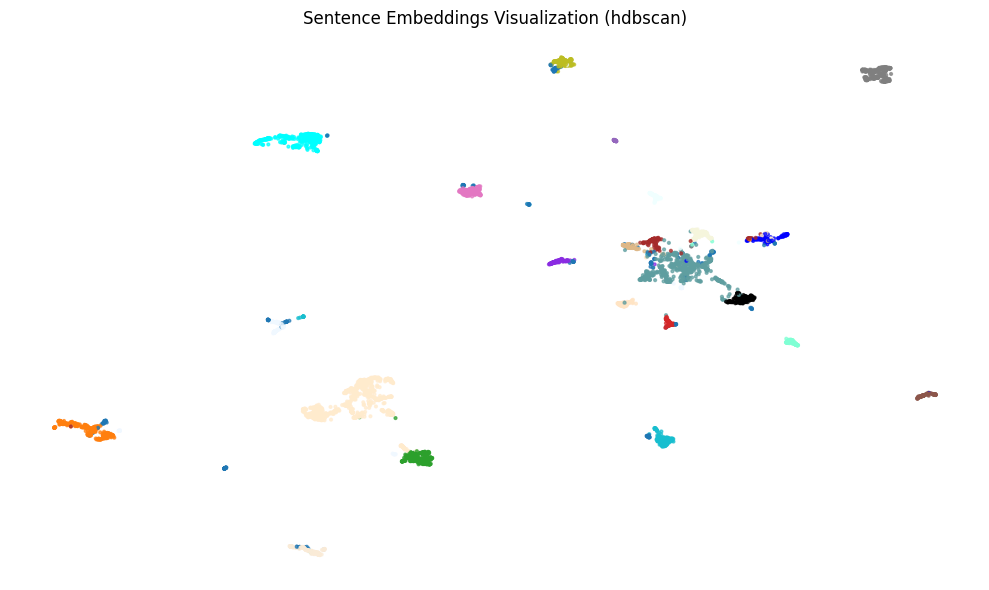

In [21]:
# Clusters visualization
from sklearn.utils import check_random_state


def plot_sentence_embeddings(embeddings, cluster_labels, clustering_method=None, max_points=5000):
    import matplotlib.colors as mcolors

    embeddings = np.array(embeddings)
    cluster_labels = np.array(cluster_labels)

    if len(embeddings) > max_points:
        rng = check_random_state(42)
        indices = rng.choice(len(embeddings), size=max_points, replace=False)
        embeddings = embeddings[indices]
        cluster_labels = cluster_labels[indices]

    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.0,
        init='random',
        metric='cosine',
        random_state=73
    )
    reduced = reducer.fit_transform(embeddings)

    unique_labels = np.unique(cluster_labels)
    num_clusters = len(unique_labels)

    color_list = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    color_list = color_list[:num_clusters]
    color_map = {label: color_list[i % len(color_list)] for i, label in enumerate(unique_labels)}

    colors = [color_map[label] for label in cluster_labels]

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=colors, s=4, alpha=0.7)
    plt.title(f"Sentence Embeddings Visualization ({clustering_method})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


plot_sentence_embeddings(final_embeddings, cluster_labels=labels, clustering_method=clustering_method)

In [22]:
%%time
run_this = False

if run_this:
    !pip install subgroups
    from subgroups.algorithms import BSD
    from subgroups.quality_measures import WRAcc
    from subgroups.quality_measures import WRAccOptimisticEstimate1

    dataset = pd.concat([features_raw, target_df], axis=1).astype(str)
    target = (target_column, target_value)
    bsd_model = BSD(min_support=subgroup_size_limit, quality_measure=WRAcc(), optimistic_estimate = WRAccOptimisticEstimate1(), num_subgroups=100, max_depth=2, write_results_in_file = True, file_path = "./results_BSD.txt" )
    bsd_model.fit(dataset, target)


CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 30.3 µs


In [23]:
def parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit):
    output_file = "results_BSD_.txt"

    with open(file_path, 'r') as file, open(output_file, 'w') as output:
        for line in file:
            match = re.search(r"(Description: \[.*?\]), Target: (.*?) ; Quality Measure WRAcc = ([\d.-]+) ; tp = (\d+) ; fp = (\d+) ; TP = (\d+) ; FP = (\d+)", line)

            if match:
                description = match.group(1)
                target = match.group(2)
                WRAcc = float(match.group(3))
                tp = int(match.group(4))
                fp = int(match.group(5))
                TP = int(match.group(6))
                FP = int(match.group(7))

                description_text = description[13:-1]
                description_length = description_text.count(',') + 1 if description_text else 1

                quality_score = Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit)

                output_line = f"{description}, Target: {target} ; QuMe = {quality_score:.8f} ; WRAcc = {WRAcc:.8f} ; tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                output.write(output_line)

if run_this:
    file_path = "results_BSD.txt"
    parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit)

In [24]:
# Overlap ratio
def compute_coverage(filename, quality_measure, k, dataset, print_subgroups=False):
    with open(filename, 'r') as file:
        lines = file.readlines()

    subgroups = []
    instance_coverage = {}

    for line in lines:
        match = re.search(rf"{quality_measure}\s*=\s*([-+]?\d*\.?\d+)\s*;.*tp\s*=\s*(\d+)\s*;\s*fp\s*=\s*(\d+)", line)
        if match:
            quality = float(match.group(1))
            tp = int(match.group(2))
            fp = int(match.group(3))

            desc_match = re.search(r"Description: \[(.*?)\]", line)
            if desc_match:
                description = desc_match.group(1).split(", ")
            else:
                description = []

            mask = pd.Series(True, index=dataset.index)
            for condition in description:
                try:
                    feature, value = condition.split(" = ")
                    value = value.strip("'")

                    if feature not in dataset.columns:
                        continue

                    mask &= dataset[feature] == value
                except ValueError:
                    continue

            covered_instances = set(dataset[mask].index)

            for instance in covered_instances:
                instance_coverage[instance] = instance_coverage.get(instance, 0) + 1

            subgroups.append((quality, covered_instances, description, line.strip()))

    subgroups.sort(reverse=True, key=lambda x: x[0])
    top_k_subgroups = subgroups[:k]

    covered_instances = set()
    filtered_instance_coverage = {}

    for _, instance_ids, _, _ in top_k_subgroups:
        covered_instances.update(instance_ids)
        for instance in instance_ids:
            filtered_instance_coverage[instance] = filtered_instance_coverage.get(instance, 0) + 1

    coverage = len(covered_instances) / len(dataset) if len(dataset) else 0
    overlapping_instances = sum(1 for count in filtered_instance_coverage.values() if count > 1)
    overlap_ratio = overlapping_instances / len(covered_instances) if covered_instances else 0

    if print_subgroups:
        print("Top-k subgroups:")
        for _, _, _, subgroup in top_k_subgroups:
            print(subgroup)

    results = {
        "coverage": coverage,
        "overlap_ratio": overlap_ratio
    }

    return results



print("SDUEBA model:")
results_SDUEBA = compute_coverage('results_SDUEBA.txt', 'QuMe', n_clusters, pd.concat([categorical_df, numerical_df, binary_df], axis=1), True)
print(f"Coverage: {results_SDUEBA['coverage']}, Overlap Ratio: {results_SDUEBA['overlap_ratio']}")
if run_this:
    print("BSD model:")
    results_BSD = compute_coverage('results_BSD_.txt', 'QuMe', n_clusters, pd.concat([categorical_df, numerical_df, binary_df], axis=1), True)
    print(f"Coverage: {results_BSD['coverage']}, Overlap Ratio: {results_BSD['overlap_ratio']}")

SDUEBA model:
Top-k subgroups:
Description: [State = 'GA'], Target: Severity = '3' ; QuMe = 0.18774527 ; WRAcc = 0.00404725 ; tp = 591 ; fp = 1075 ; TP = 12906 ; FP = 64377
Description: [State = 'IL'], Target: Severity = '3' ; QuMe = 0.17479795 ; WRAcc = 0.00383147 ; tp = 579 ; fp = 1115 ; TP = 12906 ; FP = 64377
Description: [State = 'OR'], Target: Severity = '3' ; QuMe = 0.11234294 ; WRAcc = -0.00268636 ; tp = 101 ; fp = 1747 ; TP = 12906 ; FP = 64377
Description: [State = 'WA'], Target: Severity = '3' ; QuMe = 0.09859884 ; WRAcc = 0.00134981 ; tp = 281 ; fp = 777 ; TP = 12906 ; FP = 64377
Description: [County = 'Miami-Dade'], Target: Severity = '3' ; QuMe = 0.09840317 ; WRAcc = -0.00330417 ; tp = 178 ; fp = 2417 ; TP = 12906 ; FP = 64377
Description: [State = 'MI'], Target: Severity = '3' ; QuMe = 0.08087701 ; WRAcc = 0.00172255 ; tp = 408 ; fp = 1238 ; TP = 12906 ; FP = 64377
Description: [State = 'PA'], Target: Severity = '3' ; QuMe = 0.06233376 ; WRAcc = -0.00240437 ; tp = 312 ; 